# ONE TO MANY

/tmp/ipykernel_77717/308749597.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


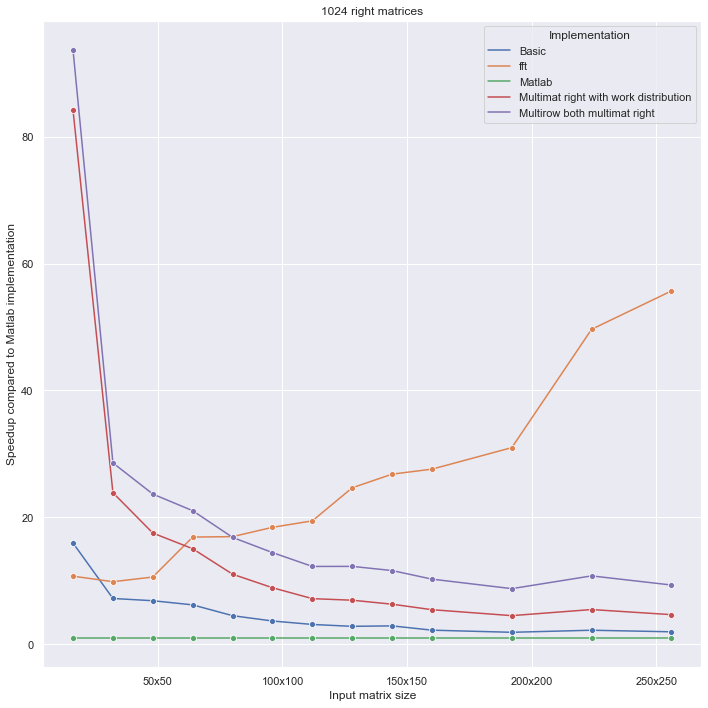

In [1]:
import re

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shared import Benchmark, Run, Group, InputSize

from pathlib import Path
from typing import List, Tuple, Dict

benchmark = Benchmark.load(Path.cwd().parent / "benchmarking" / "text" / "matlab_startup_speedup")

group = benchmark.groups["one_to_many"]

comparison_base_name = "matlab"
comparison_base_args = ""
warp_shuffle_algs_and_args = {
    "matlab": {
        "": "Matlab",
    },
    "basic": {
        "": "Basic",
    },
    "fft_orig": {
        "": "fft"
    },
    "nai_shuffle_multimat_right_work_distribution": {
        "": "Multimat right with work distribution",
    },
    "nai_shuffle_multirow_both_multimat_right": {
        "": "Multirow both multimat right"
    },
}

data = pd.concat([run.data for run in group.runs], axis=0, ignore_index=True)


def filter_data(row) -> bool:
    return row["Name"] in warp_shuffle_algs_and_args and row["Args"] in warp_shuffle_algs_and_args[row["Name"]]


data = data[data[["Name", "Args"]].apply(filter_data, axis=1)]

grouped = data.groupby(["Name", "Args", "Input right matrices", "Input matrix rows"])

computation_times = grouped["Computation"].mean() / 1e9
computation_times.name = "Computation time"
results = computation_times.reset_index()

comparison_base_times = results[(results["Name"] == comparison_base_name) & (results["Args"] == comparison_base_args)]

# TODO: Remove
# cols = ["Input right matrices", "Input matrix rows"]
# results = results[results[cols].apply(tuple, axis=1).isin(comparison_base_times[cols].apply(tuple, axis=1))]

# print(results)

def speedup(row):
    min_time = comparison_base_times[(comparison_base_times["Input right matrices"] == row["Input right matrices"]) & (
                comparison_base_times["Input matrix rows"] == row["Input matrix rows"])]["Computation time"].item()
    return min_time / row["Computation time"]


def map_name(row):
    return warp_shuffle_algs_and_args[row["Name"]][row["Args"]]


results["Speedup"] = results.apply(speedup, axis=1)
results["Implementation"] = results.apply(map_name, axis=1)

sns.set(rc={'figure.figsize': (10, 10)})
for right_matrices in sorted(results["Input right matrices"].unique()):
    fig, ax = plt.subplots()
    r_mat_results = results[results["Input right matrices"] == right_matrices]
    ax = sns.lineplot(data=r_mat_results, x="Input matrix rows", y="Speedup", hue="Implementation", marker='o', ax=ax)
    ticks = ax.get_xticks()
    ticks = [f"{int(num_rows)}x{int(num_rows)}" for num_rows in ticks]
    ax.set_xticklabels(ticks)
    ax.set_xlabel("Input matrix size")
    ax.set_ylabel(
        f"Speedup compared to {warp_shuffle_algs_and_args[comparison_base_name][comparison_base_args]} implementation")
    ax.set_title(f"{right_matrices} right matrices")
    fig.tight_layout()